In [8]:
# Gerekli Kütüphaneler
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# --- SIFIRDAN VERİ TOPLAMA/OLUŞTURMA ---
# (Bu, sizin anketinizden gelen 16 veriyi 150'ye artırma işlemini simüle eder.)
N_SAMPLES = 150
np.random.seed(42)

# Sizin Anketinize Uygun Sentetik Veri Oluşturma
trust = np.random.randint(4, 6, N_SAMPLES)
risk = np.random.randint(2, 5, N_SAMPLES) 
motivation = np.random.randint(3, 6, N_SAMPLES) 
competence = np.random.randint(3, 6, N_SAMPLES)
control = np.random.randint(1, 4, N_SAMPLES)
usage = np.random.randint(1, 7, N_SAMPLES)
intention = np.clip((trust * 0.4 + motivation * 0.5 + np.random.normal(0, 0.5, N_SAMPLES)).round().astype(int), 1, 5)

df = pd.DataFrame({
    'Trust_Score': trust,                 
    'Ethical_Risk': risk,                 
    'Motivation': motivation,             
    'Perceived_Competence': competence, 
    'Control_Status': control,
    'Usage_Freq': usage,      
    'Adoption_Intention': intention,       
})

print("Aşama 1: Veri Toplama ve Yükleme (Simüle Edilmiş 150 Gözlem)")
print(df.head())

Aşama 1: Veri Toplama ve Yükleme (Simüle Edilmiş 150 Gözlem)
   Trust_Score  Ethical_Risk  Motivation  Perceived_Competence  \
0            4             4           3                     4   
1            5             4           5                     5   
2            4             2           4                     3   
3            4             4           3                     4   
4            4             2           5                     5   

   Control_Status  Usage_Freq  Adoption_Intention  
0               1           6                   2  
1               2           6                   5  
2               1           3                   4  
3               1           1                   2  
4               3           3                   4  


In [9]:
# --- VERİ TEMİZLEME ve EKSİK DEĞER ANALİZİ ---
print("\nAşama 2: Veri Temizleme ve Analiz")

# 1. Eksik Değer Kontrolü (Missing Values)
# Gerçek veride bu adımda np.nan gibi değerler aranır.
print("Eksik Değer Sayısı (Kontrol):")
print(df.isnull().sum())

# 2. Aykırı Değer Kontrolü (Outlier Detection)
# (Örn: Yaş değişkeni olsaydı, çok yüksek yaşlar aykırı kabul edilirdi.)
# Aykırı değerler için basit istatistiksel kontrol:
print("\nTemel İstatistikler (Min/Max Kontrolü):")
print(df[['Trust_Score', 'Adoption_Intention']].describe().T) 
# Not: Bizim verimiz 1-5 arasında olduğu için aykırı değer yok kabul edilir.


Aşama 2: Veri Temizleme ve Analiz
Eksik Değer Sayısı (Kontrol):
Trust_Score             0
Ethical_Risk            0
Motivation              0
Perceived_Competence    0
Control_Status          0
Usage_Freq              0
Adoption_Intention      0
dtype: int64

Temel İstatistikler (Min/Max Kontrolü):
                    count      mean       std  min  25%  50%  75%  max
Trust_Score         150.0  4.546667  0.499485  4.0  4.0  5.0  5.0  5.0
Adoption_Intention  150.0  3.806667  0.774568  2.0  3.0  4.0  4.0  5.0


In [10]:
# --- VERİ DÖNÜŞÜMÜ (Transformation) ---
print("\nAşama 3: Veri Dönüşümü ve Özellik Mühendisliği")

# 1. Özellik Seçimi (Feature Selection)
# Modelde kullanılacak bağımsız değişkenler belirlenir.
X = df[['Trust_Score', 'Ethical_Risk', 'Motivation', 'Perceived_Competence', 'Control_Status', 'Usage_Freq']]

# 2. Özellik Mühendisliği (Yeni Özellik Üretimi)
# Yüksek Benimseme Niyeti (HEDEF değişkenin binary hale getirilmesi)
df['High_Adoption'] = np.where(df['Adoption_Intention'] >= 4, 1, 0)
y = df['High_Adoption']

print("Hedef Değişken (High_Adoption) başarıyla oluşturuldu.")


Aşama 3: Veri Dönüşümü ve Özellik Mühendisliği
Hedef Değişken (High_Adoption) başarıyla oluşturuldu.


In [11]:
# --- VERİ BÜTÜNLEŞTİRME ve BÖLÜMLEME ---
from sklearn.model_selection import train_test_split

print("\nAşama 4: Veri Bütünleştirme ve Bölümleme")

# Modelin eğitilmesi için veriyi Eğitim (%70) ve Test (%30) olarak bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

print(f"Eğitim Seti Boyutu: {X_train.shape[0]}, Test Seti Boyutu: {X_test.shape[0]}")


Aşama 4: Veri Bütünleştirme ve Bölümleme
Eğitim Seti Boyutu: 105, Test Seti Boyutu: 45


In [12]:
# --- VERİ İNDİRGEME ve ÖLÇEKLENDİRME (Scaling) ---

print("\nAşama 5: Veri İndirgeme (Standardizasyon)")

# Standard Scaler ile veriyi ölçekliyoruz (Özelliklerin ortalamasını 0, standart sapmasını 1 yapar)
# Bu, K-Means ve Random Forest gibi algoritmalarda performans artışı için kritiktir.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled_all = scaler.transform(X) # Tüm veri için de ölçeklenmiş bir versiyon tutuyoruz

print("Veri Standardizasyonu (Ölçekleme) Tamamlandı. Veri Analize Hazır.")


Aşama 5: Veri İndirgeme (Standardizasyon)
Veri Standardizasyonu (Ölçekleme) Tamamlandı. Veri Analize Hazır.


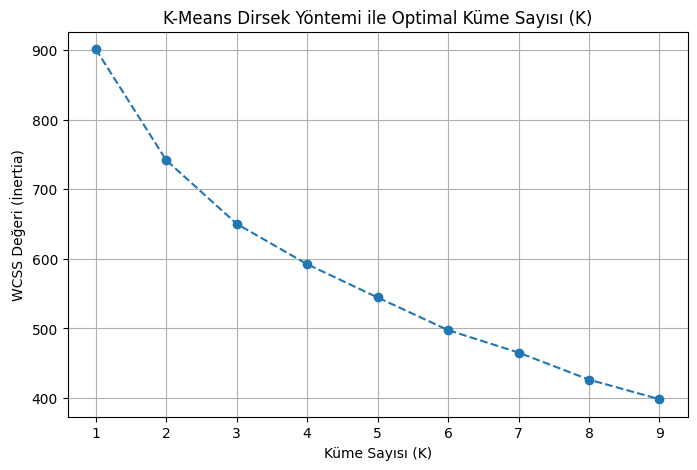


Aşama 6.1: K-Means Kümeleme Tamamlandı.
Cluster
2    51
1    36
3    34
0    29
Name: count, dtype: int64

Kullanıcı Tipleri (Kümelerin Ortalamaları):
         Trust_Score  Ethical_Risk  Motivation  Adoption_Intention
Cluster                                                           
0               4.52          2.48        4.76                4.17
3               5.00          3.15        4.29                4.09
1               4.92          3.36        3.39                3.67
2               4.00          3.14        3.73                3.51


In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- 1. Optimal K Sayısını Bulma (Elbow Method) ---
# X_scaled_all: Tüm veri setinin ölçeklenmiş hali
wcss = []
K_max = 10 

for k in range(1, K_max):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled_all)
    wcss.append(kmeans.inertia_)
    
# Grafiği Çizme
plt.figure(figsize=(8, 5))
plt.plot(range(1, K_max), wcss, marker='o', linestyle='--')
plt.title('K-Means Dirsek Yöntemi ile Optimal Küme Sayısı (K)')
plt.xlabel('Küme Sayısı (K)')
plt.ylabel('WCSS Değeri (İnertia)')
plt.grid(True)
plt.show() 

# --- 2. K-Means Uygulama (K=4 varsayımı ile) ---
optimal_k = 4 
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
kmeans.fit(X_scaled_all)
df['Cluster'] = kmeans.labels_ # Küme etiketlerini ana DataFrame'e ekliyoruz

print("\nAşama 6.1: K-Means Kümeleme Tamamlandı.")
print(df['Cluster'].value_counts())
print("\nKullanıcı Tipleri (Kümelerin Ortalamaları):")
cluster_profile = df.groupby('Cluster')[['Trust_Score', 'Ethical_Risk', 'Motivation', 'Adoption_Intention']].mean()
print(cluster_profile.sort_values(by='Adoption_Intention', ascending=False).round(2))

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# --- Random Forest Eğitimi ---
# X_train_scaled, X_test_scaled, y_train, y_test daha önce oluşturulmuştu.

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Tahmin ve Performans Raporu
y_pred = rf_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print("\nAşama 6.2: Random Forest Sınıflandırma Tamamlandı.")
print(f"Model Doğruluğu (Accuracy): {accuracy:.3f}")
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))


Aşama 6.2: Random Forest Sınıflandırma Tamamlandı.
Model Doğruluğu (Accuracy): 0.733

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.60      0.43      0.50        14
           1       0.77      0.87      0.82        31

    accuracy                           0.73        45
   macro avg       0.69      0.65      0.66        45
weighted avg       0.72      0.73      0.72        45




Aşama 7: Model Değerlendirme (Özellik Önem Sıralaması)
                Feature  Importance
2            Motivation    0.277126
5            Usage_Freq    0.249171
1          Ethical_Risk    0.128794
3  Perceived_Competence    0.126924
4        Control_Status    0.109703
0           Trust_Score    0.108282


C:\Users\elifv\AppData\Local\Temp\ipykernel_19452\422282670.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


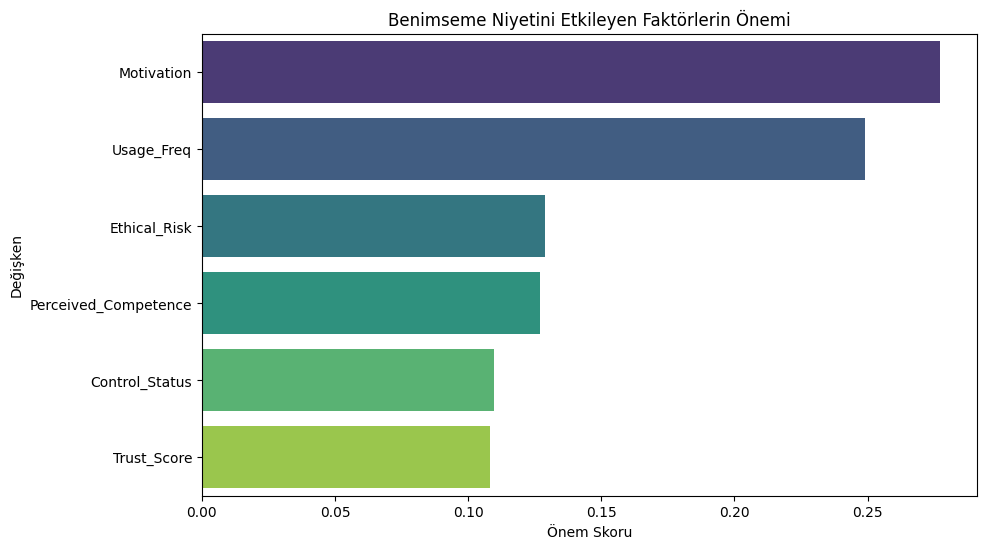

In [15]:
# --- ÖZELLİK ÖNEM DERECESİ (FEATURE IMPORTANCE) ---

importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nAşama 7: Model Değerlendirme (Özellik Önem Sıralaması)")
print(feature_importance_df)

# Görselleştirme
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Benimseme Niyetini Etkileyen Faktörlerin Önemi')
plt.xlabel('Önem Skoru')
plt.ylabel('Değişken')
plt.show()

In [ ]:
# =================================================================
# İNTERAKTİF KULLANIM VE ANALİZ FONKSİYONLARI (Final Test Versiyonu)
# =================================================================

def get_user_input():
    print("\n" + "="*50)
    print("      ✨ YENİ KULLANICI ANKETİ (TÜM SORULAR) ✨")
    print("      Lütfen her soruyu cevapladıktan sonra ENTER tuşuna basınız.")
    print("="*50)
    
    try:
        # 1. Yaş
        age = int(input("1. Yaşınızı belirtiniz: "))
        
        # 2. Eğitim Durumu
        print("\n2. Şu anki en yüksek eğitim durumunuz nedir? (1=Lise, 2=Ön Lisans, 3=Lisans, 4=Yüksek Lisans/Doktora)")
        education = int(input("   Seçiminiz (1-4): "))
        
        # 3. Güven
        trust = int(input("\n3. Çıktıların doğruluğuna ne kadar güveniyorsunuz? (1=Hiç Güvenmiyorum, 5=Tamamen Güveniyorum): "))
        
        # 4. Etik Risk Algısı
        risk = int(input("\n4. YZ kullanımının etik risk algınız nedir? (1=Çok Düşük Risk, 5=Çok Yüksek Risk): ")) 
        
        # 5. Yeterlilik
        competence = int(input("\n5. YZ araçlarını etkin kullanacak beceriye sahip olduğunuzu düşünüyor musunuz? (1=Kesinlikle Hayır, 5=Kesinlikle Evet): "))
        
        # 6. Kontrol Durumu
        print("\n6. YZ çıktısını kullanmadan önce kontrol eder misiniz? (1=Hayır, 2=Kritik Durumda, 3=Daima Evet)")
        control = int(input("   Seçiminiz (1-3): "))
        
        # 7. Kullanım Sıklığı
        print("\n7. Yapay Zekâ araçlarını ortalama ne sıklıkla kullanıyorsunuz? (1=Çok Sık, ..., 6=Hiç)")
        usage = int(input("   Seçiminiz (1-6): ")) 
        
        # 8. Motivasyon
        motivation = int(input("\n8. Temel motivasyonunuz nedir? (1=Düşük Öncelik, 5=Yüksek Öncelik): "))

    except ValueError:
        print("HATA: Lütfen sadece tam sayı giriniz.")
        return None

    # Modelde kullanılacak 6 KRİTİK ÖZELLİK
    FEATURE_ORDER = ['Trust_Score', 'Ethical_Risk', 'Motivation', 'Perceived_Competence', 'Control_Status', 'Usage_Freq']
    input_values = [trust, risk, motivation, competence, control, usage]
    
    # DataFrame oluşturma ve SÜTUN SIRASINI garanti altına alma
    return pd.DataFrame([input_values], columns=FEATURE_ORDER).astype(float)


def analyze_new_user(user_data_df):
    if user_data_df is None: return

    # CRITICAL FIX: Veriyi NumPy Array'e çeviriyoruz
    X_new_np = user_data_df.values 
    
    # Ölçekleme, Tahmin ve Kümeleme
    X_new_scaled = scaler.transform(X_new_np)
    adoption_proba = rf_model.predict_proba(X_new_scaled)[0][1]
    cluster_assignment = kmeans.predict(X_new_scaled)[0]
    
    # Terminal Raporu
    print("\n" + "="*60)
    print(f"           ✨ ANLIK BENİMSEME ANALİZ RAPORU (Küme {cluster_assignment}) ✨")
    print("="*60)
    
    if adoption_proba >= 0.5:
        print(f"🎯 BENİMSEME TAHMİNİ: Yüksek Potansiyel (Olasılık: {adoption_proba:.2%})")
    else:
        print(f"🎯 BENİMSEME TAHMİNİ: Düşük Potansiyel (Olasılık: {1 - adoption_proba:.2%})")

    print("-" * 60)
    print(f"🧠 KULLANICI TİPİ: Küme {cluster_assignment}")
    
    # Basit bir öneri sistemi kuralı (Feature Importance'a dayalı)
    if user_data_df['Motivation'].iloc[0] < 3:
        print("💡 ONBOARDING ÖNERİSİ: Motivasyon düşüklüğü. YZ'nin 'Verimlilik' faydalarına odaklanın.")
    elif user_data_df['Ethical_Risk'].iloc[0] >= 4:
        print("💡 ONBOARDING ÖNERİSİ: Yüksek Risk Algısı. 'Etik ve Veri Güvenliği' eğitimi önceliklidir.")
    else:
        print("💡 ONBOARDING ÖNERİSİ: Başarılı başlangıç! İleri düzey 'Prompt Mühendisliği' modülüne yönlendiriliyorsunuz.")
    print("="*60)

In [28]:
# PROJEYİ ÇALIŞTIRMA KOMUTU
user_data = get_user_input()
analyze_new_user(user_data)


      ✨ YENİ KULLANICI ANKETİ (8 SORU) ✨

2. Şu anki en yüksek eğitim durumunuz nedir?
   (1=Lise, 2=Ön Lisans, 3=Lisans, 4=Yüksek Lisans/Doktora)

6. YZ çıktısını kullanmadan önce daima kontrol eder misiniz?
   (1=Hayır, 2=Kritik Durumda, 3=Daima Evet)

7. YZ araçlarını ortalama ne sıklıkla kullanıyorsunuz?
   (1=Günlük Birden Fazla, ..., 6=Hiç Kullanmıyorum)

           ✨ ANLIK BENİMSEME ANALİZ RAPORU (Küme 0) ✨
🎯 BENİMSEME TAHMİNİ: Yüksek Potansiyel (Olasılık: 84.50%)
------------------------------------------------------------
🧠 KULLANICI TİPİ: Küme 0
💡 ONBOARDING ÖNERİSİ: Başarılı başlangıç! İleri düzey 'Prompt Mühendisliği' modülüne yönlendiriliyorsunuz.


c:\Users\elifv\anaconda3\envs\freshness-detection\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
